In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import argparse

In [65]:
def pre_process(df):
    df = df.rename(columns={
        '年月': 'year_month',
        '销售凭证日期': 'datetime',
        '物料编码': 'unique_id',
        '进单数量': 'y',
        '折前含税金额':'mount'
    })
    df = df.groupby(['year_month','unique_id'], as_index=False).agg({'y':'sum', 'mount':'sum'}) 
    df['price'] = df['mount'] / df['y']
    # df = df[['datetime', 'unique_id', 'price', 'y']]
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y%m')
    df['year'] = df['year_month'].dt.year
    df['month'] = df['year_month'].dt.month
    # print(df.head())
    df_year = pd.DataFrame({'year':df['year'].unique(),'j':-1})
    df_month =  pd.DataFrame({'month':range(1,13),'j':-1})
    df_id = pd.DataFrame({'unique_id':df['unique_id'].unique(),'j':-1})
    df_year_month = pd.merge(df_year,df_month)
    df_year_month = df_year_month[~((df_year_month['year']==df['year'].max())&(df_year_month['month']>df['year_month'].max().month))]
    df_year_month_id = pd.merge(df_year_month,df_id)[['year','month','unique_id']]
    df = pd.merge(df_year_month_id,df,how='left')
    df['year_month'] = df.apply(lambda x:datetime.date(x['year'],x.month,1),axis=1)
    df['y'] =df['y'].fillna(0)
    df = df.sort_values(by=['unique_id','year_month'])
    df = df.groupby(['unique_id'], as_index=False).apply(lambda group: group.ffill())
    df = df.groupby(['unique_id'], as_index=False).apply(lambda group: group.bfill())
    df["time_idx"] = df["year"] * 12 + df["month"]
    df["time_idx"] -= df["time_idx"].min()
    df["month"] = df["month"].astype(str).astype("category")
    df["year"] = df["year"].astype(str).astype("category")
    df['unique_id'] = df['unique_id'].astype(str).astype("category")
    df['y'] = df['y'].astype('float')
    df["log_y"] = np.log(df.y + 1e-8)
    df["avg_y_by_id"] = df.groupby(["unique_id"],
                                   observed=True).y.transform("mean")
    return df

In [134]:
def bulid_data_loader(data, forecast):
    max_prediction_length = forecast
    max_encoder_length = forecast * 4
    training_cutoff = data["time_idx"].max() - max_prediction_length
    filter_date = training_cutoff-max_encoder_length//2
    id_min_idx = data[data['y']>0].groupby(['unique_id']).time_idx.min()
    # print(id_min_idx[id_min_idx>filter_date].index)
    print(data.shape)
    data = data[~data['unique_id'].isin(id_min_idx[id_min_idx>filter_date].index)]
    print(data.shape)
    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="y",
        group_ids=["unique_id"],
        min_encoder_length=max_encoder_length //
        2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["unique_id"],
        time_varying_known_categoricals=["month"],
        time_varying_known_reals=["time_idx", "price"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            "y",
            "log_y",
            "avg_y_by_id",
        ],
        target_normalizer=GroupNormalizer(
            groups=["unique_id"],
            transformation="softplus"),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        # allow_missing_timesteps=True
    )
    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 128 # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
    return data,training,train_dataloader,val_dataloader

In [2]:
df_full = pd.read_csv('./data/20230316.csv')

In [6]:
set(df_full.columns)-set(['cml_or_qty'])

{'amont_total', 'date', 'item_code', 'item_name', 'ymonth'}

In [136]:
df_full = pre_process(df_full)

In [13]:
df_full[(df_full['item_code']=='000E155E93AC7F454684F7B48B59C169')].head()

,ymonth,date,item_code,item_name,cml_or_qty,amont_total,test
1079,202209,20220930,000E155E93AC7F454684F7B48B59C169,8D38C7EE71FCF40E0B462865A54E4193,2,558.44,202209
13229,202209,20220928,000E155E93AC7F454684F7B48B59C169,8D38C7EE71FCF40E0B462865A54E4193,1,279.22,202209
49274,202209,20220924,000E155E93AC7F454684F7B48B59C169,8D38C7EE71FCF40E0B462865A54E4193,1,279.22,202209
66757,202111,20211115,000E155E93AC7F454684F7B48B59C169,8D38C7EE71FCF40E0B462865A54E4193,1,242.80,20211115
114493,202212,20221201,000E155E93AC7F454684F7B48B59C169,8D38C7EE71FCF40E0B462865A54E4193,1,279.22,20221201


In [12]:
df_full['test'] = df_full.apply(lambda row: row['ymonth'] if row['ymonth']==202209 else row['date'], axis = 1)

In [137]:
df_filter,training,train_dataloader,val_dataloader =  bulid_data_loader(df_full, 4)

(355030, 10)
(267982, 10)


In [93]:
def train_step_1(training,train_dataloader,val_dataloader):
    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        gpus=0,
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
        
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=0.03,
        hidden_size=16,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=2,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=8,  # set to <= hidden_size
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        # reduce learning rate if no improvement in validation loss after x epochs
        reduce_on_plateau_patience=4,
        optimizer='adam'
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    # find optimal learning rate
    res = trainer.tuner.lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
        early_stop_threshold=None
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 186.9k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/shnguo/github/opple/.lr_find_f058584b-e0fe-4742-b865-7649567faaaa.ckpt
Restored all states from the checkpoint file at /Users/shnguo/github/opple/.lr_find_f058584b-e0fe-4742-b865-7649567faaaa.ckpt


suggested learning rate: 8.511380382023763


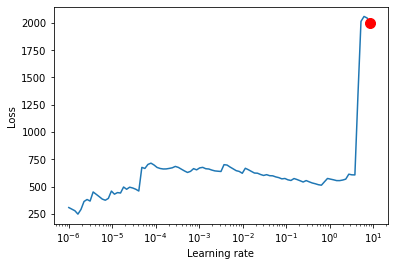

/var/folders/z0/7rx60pmj3p7dwb0h_crtphrm0000gn/T/ipykernel_97889/83556059.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [94]:
train_step_1(training,train_dataloader,val_dataloader)

In [97]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 186.6k


In [98]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 164 K 
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [99]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

557.8556518554688

In [100]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(580.9841)

In [117]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [161]:
training.filter(lambda x: (x.unique_id == "2E6531FE6B2B0D83DC76D60379178F40"))

TimeSeriesDataSet[length=25](
	time_idx='time_idx',
	target='y',
	group_ids=['unique_id'],
	weight=None,
	max_encoder_length=16,
	min_encoder_length=8,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=4,
	static_categoricals=['unique_id'],
	static_reals=['encoder_length', 'y_center', 'y_scale'],
	time_varying_known_categoricals=['month'],
	time_varying_known_reals=['time_idx', 'price', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['y', 'log_y', 'avg_y_by_id'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['unique_id'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
),
	categorical_encoders={'__group_id__unique_id': NaNLabelEncoder(add_nan=False, warn=True), 'unique_id': NaNLabelEncoder(add_nan=Fals

In [164]:
best_tft.predict(df_filter[df_filter.unique_id == "2E6531FE6B2B0D83DC76D60379178F40"])

tensor([[3.2896e-20, 3.7346e-19, 3.5671e-18, 7.8482e-18]])

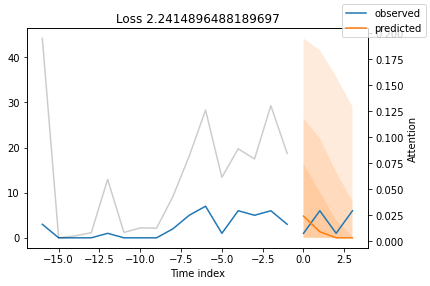

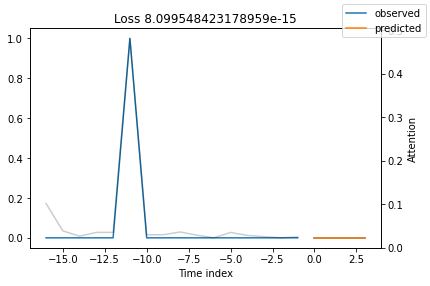

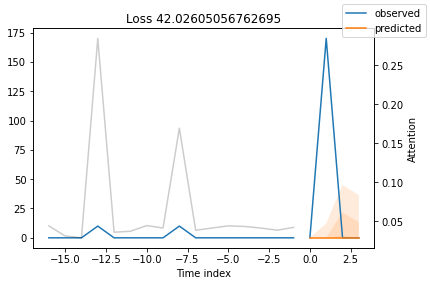

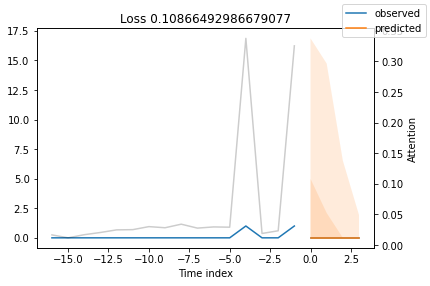

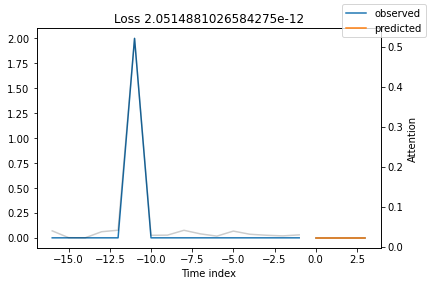

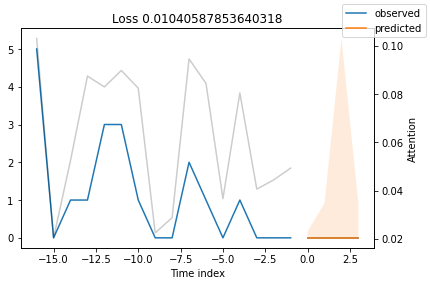

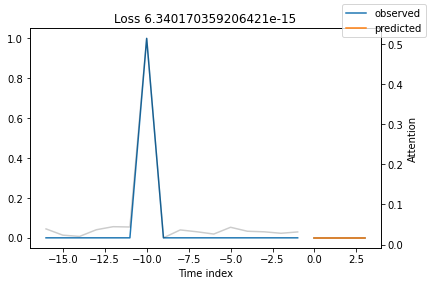

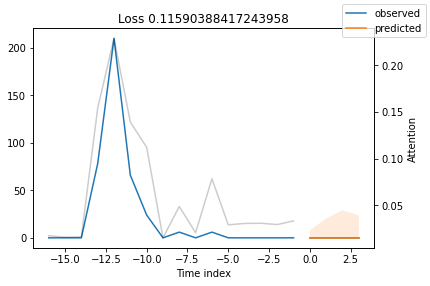

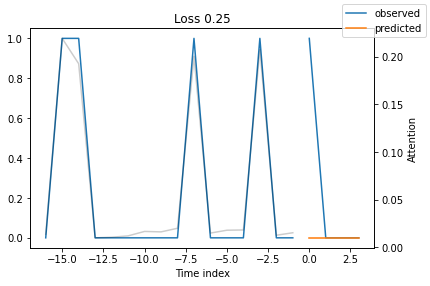

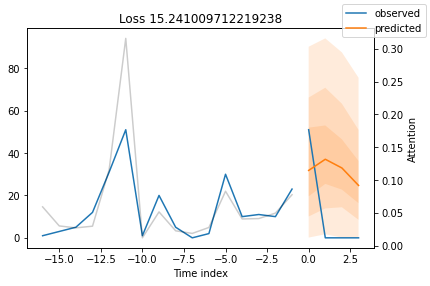

In [102]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

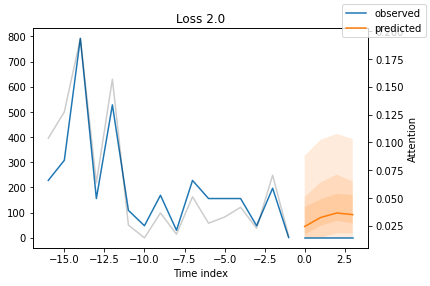

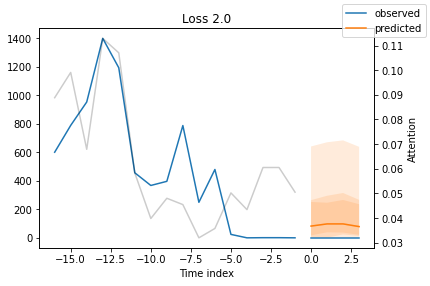

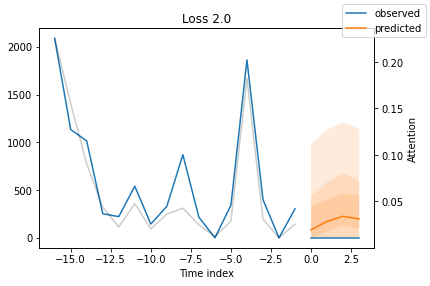

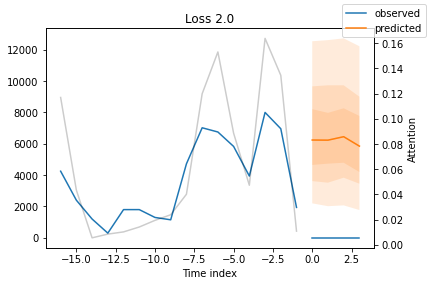

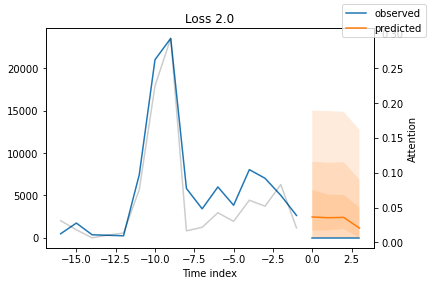

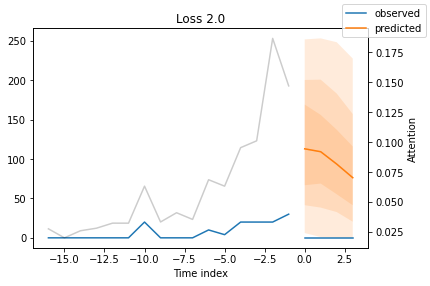

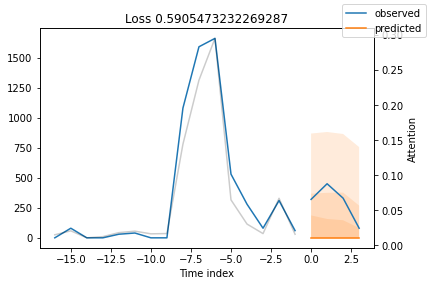

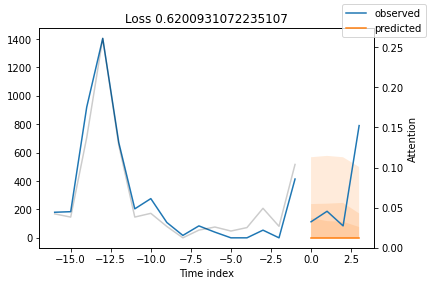

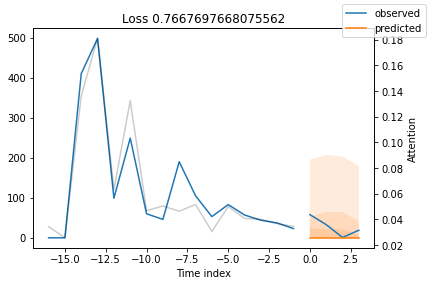

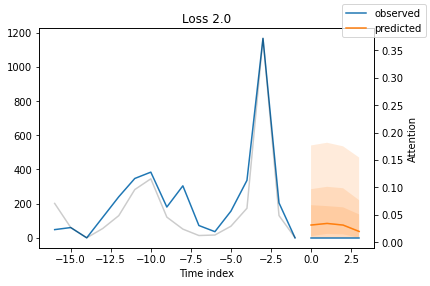

In [112]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [115]:
predictions.size()

torch.Size([10307, 4])

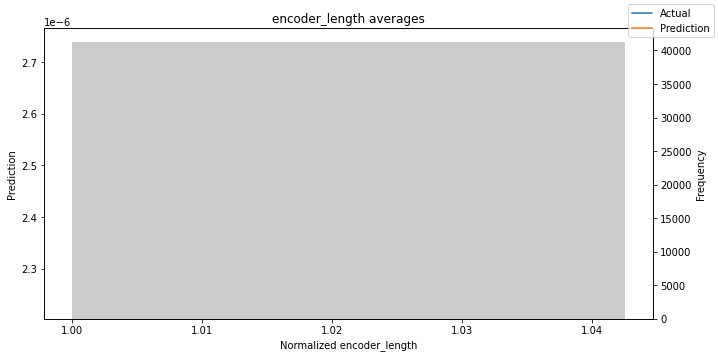

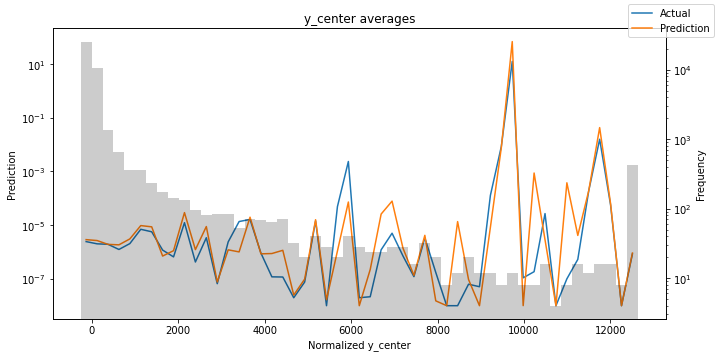

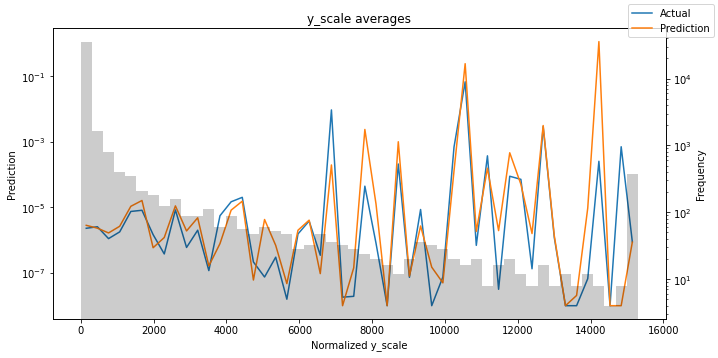

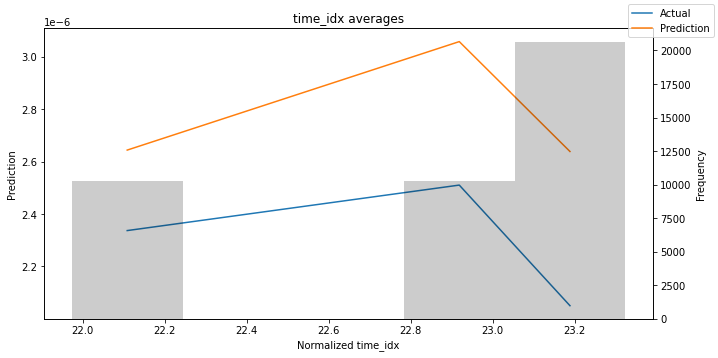

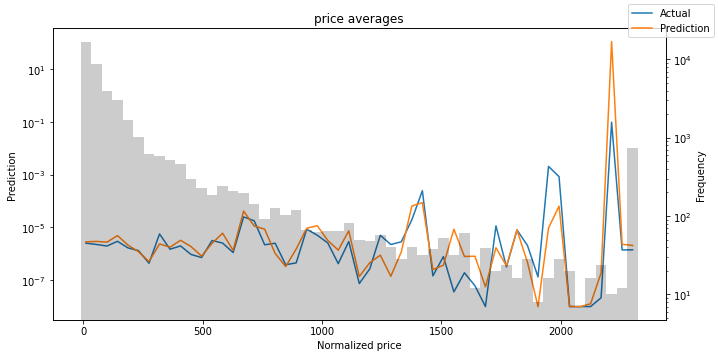

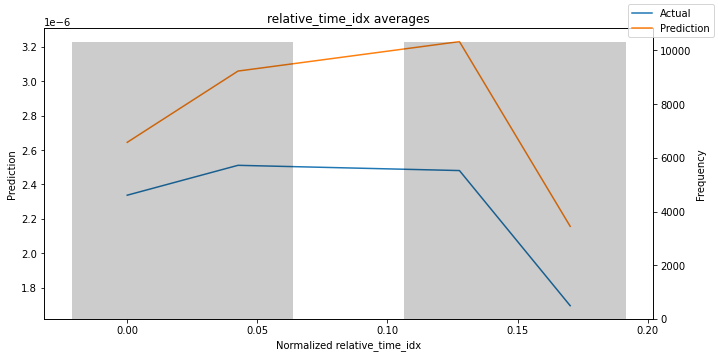

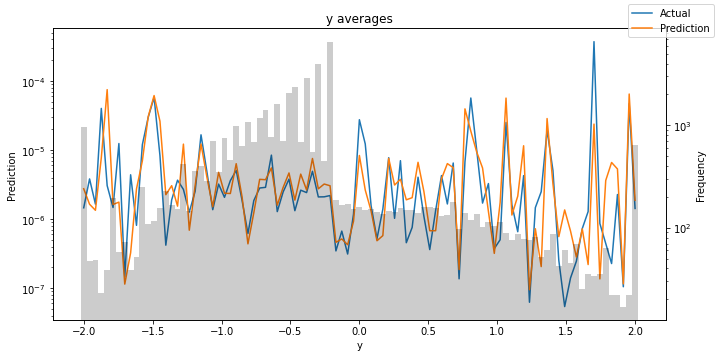

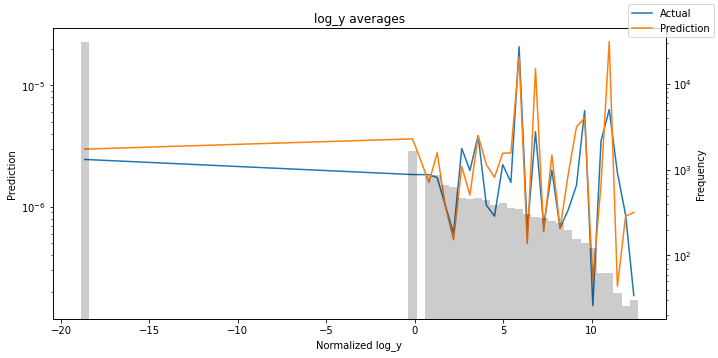

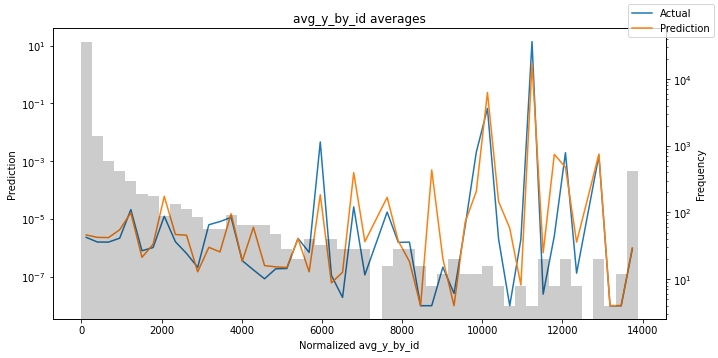

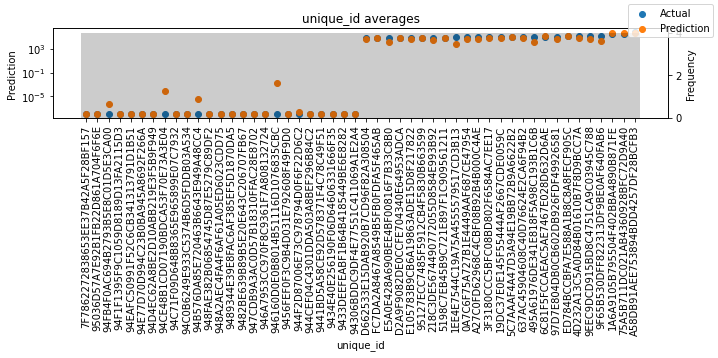

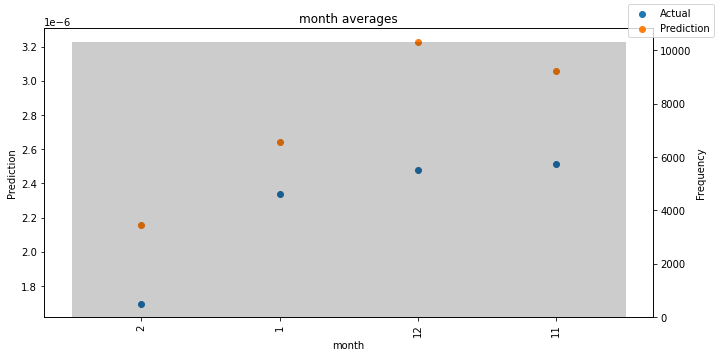

In [104]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

({'x_cat': tensor([[ 0,  0],
          [ 0,  4],
          [ 0,  5],
          [ 0,  6],
          [ 0,  7],
          [ 0,  8],
          [ 0,  9],
          [ 0, 10],
          [ 0, 11],
          [ 0,  1],
          [ 0,  2],
          [ 0,  3],
          [ 0,  0],
          [ 0,  4],
          [ 0,  5],
          [ 0,  6],
          [ 0,  7],
          [ 0,  8],
          [ 0,  9],
          [ 0, 10]]),
  'x_cont': tensor([[ 1.0000, -0.1083, -0.1030, -1.6550,  0.0104, -1.0000, -0.8894, -0.8299,
           -0.1036],
          [ 1.0000, -0.1083, -0.1030, -1.4974,  0.0104, -0.9375, -0.8894, -0.8299,
           -0.1036],
          [ 1.0000, -0.1083, -0.1030, -1.3398,  0.0104, -0.8750, -0.8894, -0.8299,
           -0.1036],
          [ 1.0000, -0.1083, -0.1030, -1.1822,  0.0104, -0.8125, -0.8894, -0.8299,
           -0.1036],
          [ 1.0000, -0.1083, -0.1030, -1.0245,  0.0104, -0.7500, -0.8894, -0.8299,
           -0.1036],
          [ 1.0000, -0.1083, -0.1030, -0.8669,  0.0104, -0.

In [125]:
df_full.sample()

,year,month,unique_id,year_month,y,mount,price,time_idx,log_y,avg_y_by_id
138032,2021,11,5A5487E1D62AE7FE89CF1460330C39D0,2021-11-01,40.0,272.16,6.804,10,3.688879,10.0


In [153]:
# select last 24 months from data (max_encoder_length is 24)
max_encoder_length=16
max_prediction_length = 4
encoder_data = df_filter[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = df_filter[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(year_month=lambda x: x.year_month + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["year_month"].dt.year * 12 + decoder_data["year_month"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.year_month.dt.month.astype(str).astype("category")  # categories have be strings
decoder_data['year_month'] = decoder_data['year_month'].dt.date
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

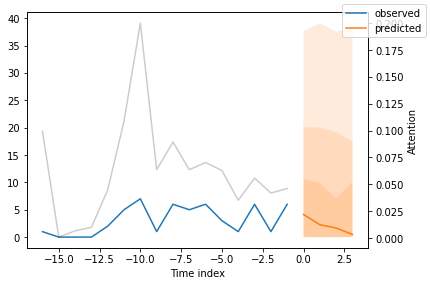

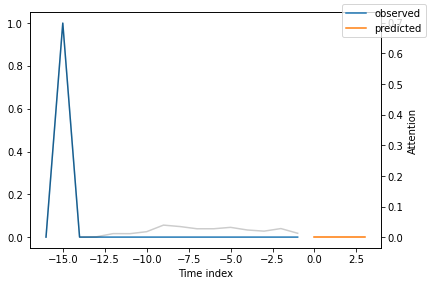

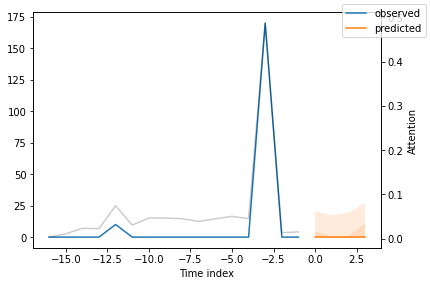

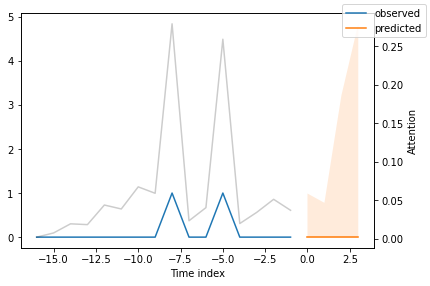

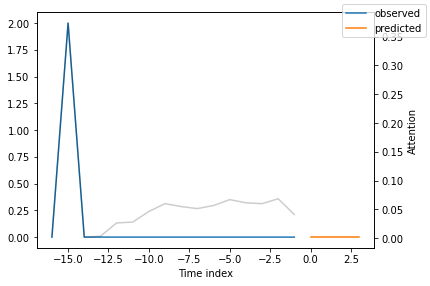

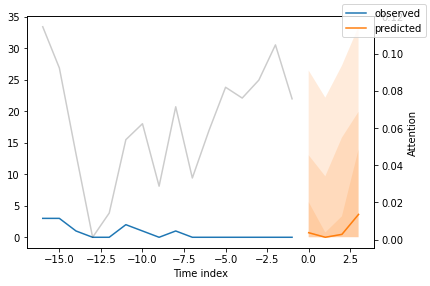

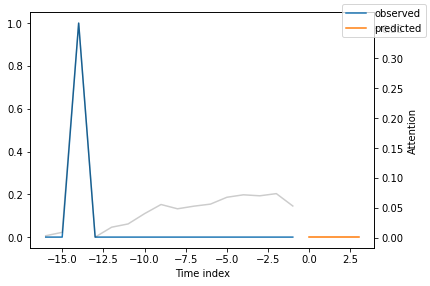

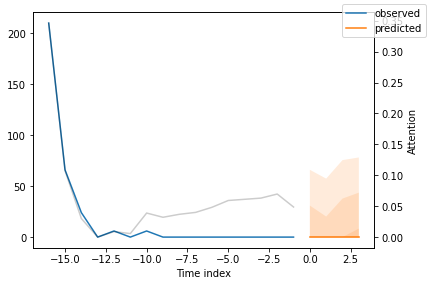

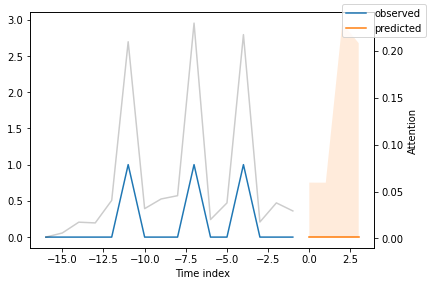

Error in callback <function flush_figures at 0x17f873790> (for post_execute):


KeyboardInterrupt: 

In [145]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [142]:
best_tft.predict(new_prediction_data[new_prediction_data['unique_id']=='2E6531FE6B2B0D83DC76D60379178F40'])[0]

tensor([[7.1568e-09, 5.8196e-08, 1.4513e-07, 5.5813e-08]])

In [157]:
testa = new_prediction_data[new_prediction_data['unique_id']=='2E6531FE6B2B0D83DC76D60379178F40'][-4:]

In [158]:
testa['y'] = best_tft.predict(new_prediction_data[new_prediction_data['unique_id']=='2E6531FE6B2B0D83DC76D60379178F40'])[0]

In [159]:
testa

,year,month,unique_id,year_month,y,mount,price,time_idx,log_y,avg_y_by_id
166785,2023,3,2E6531FE6B2B0D83DC76D60379178F40,2023-03-01,7.156797e-09,75.37,75.37,26,-18.420681,0.115385
177092,2023,4,2E6531FE6B2B0D83DC76D60379178F40,2023-04-01,5.819648e-08,75.37,75.37,27,-18.420681,0.115385
187399,2023,5,2E6531FE6B2B0D83DC76D60379178F40,2023-05-01,1.451308e-07,75.37,75.37,28,-18.420681,0.115385
197706,2023,6,2E6531FE6B2B0D83DC76D60379178F40,2023-06-01,5.581297e-08,75.37,75.37,29,-18.420681,0.115385


In [165]:
testb = pd.DataFrame()

In [168]:
testb = pd.concat([testb,testa],ignore_index=True)

In [170]:
testb.to_dict('list')

{'year': ['2023', '2023', '2023', '2023', '2023', '2023', '2023', '2023'],
 'month': ['3', '4', '5', '6', '3', '4', '5', '6'],
 'unique_id': ['2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40',
  '2E6531FE6B2B0D83DC76D60379178F40'],
 'year_month': [datetime.date(2023, 3, 1),
  datetime.date(2023, 4, 1),
  datetime.date(2023, 5, 1),
  datetime.date(2023, 6, 1),
  datetime.date(2023, 3, 1),
  datetime.date(2023, 4, 1),
  datetime.date(2023, 5, 1),
  datetime.date(2023, 6, 1)],
 'y': [7.156797376950408e-09,
  5.819647697080654e-08,
  1.451308122568662e-07,
  5.5812968469126645e-08,
  7.156797376950408e-09,
  5.819647697080654e-08,
  1.451308122568662e-07,
  5.5812968469126645e-08],
 'mount': [75.37, 75.37, 75.37, 75.37, 75.37, 75.37, 75.37, 75.37],
 'price': [75.37, 75.37, 75.37, 